In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
print(df.head())


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [3]:
# Drop ID and handle missing values
df.drop('Id', axis=1, inplace=True)
numerical = df.select_dtypes(include=[np.number])
categorical = df.select_dtypes(exclude=[np.number])

In [4]:
# Impute missing values
df[numerical.columns] = SimpleImputer(strategy='median').fit_transform(numerical)
df[categorical.columns] = SimpleImputer(strategy='constant', fill_value='None').fit_transform(categorical)

In [5]:
# Encode categorical features
for col in categorical.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [6]:
# Clustering neighborhoods based on characteristics
cluster_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[cluster_features])
print("Cluster distribution:\n", df['Cluster'].value_counts())

Cluster distribution:
 Cluster
1    579
0    398
3    343
2    139
4      1
Name: count, dtype: int64


In [7]:
# Feature selection
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)
top_features = X.columns[selector.get_support()] 
print("Top 10 important features:\n", top_features)

Top 10 important features:
 Index(['OverallQual', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'KitchenQual', 'GarageCars', 'GarageArea'],
      dtype='object')


In [8]:
# Final data split
X = df[top_features]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R^2: 0.8807360401138844
Random Forest RMSE: 30245.553013416476


In [10]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear Regression R^2: 0.8163235836404459
Linear Regression RMSE: 37534.75762603113


In [11]:
# Identify undervalued properties
test_df = X_test.copy()
test_df['ActualPrice'] = y_test
test_df['PredictedPrice'] = y_pred_rf
test_df['Delta'] = test_df['ActualPrice'] - test_df['PredictedPrice']
undervalued = test_df[test_df['Delta'] > 20000]
print("Undervalued properties found:", len(undervalued))

Undervalued properties found: 48


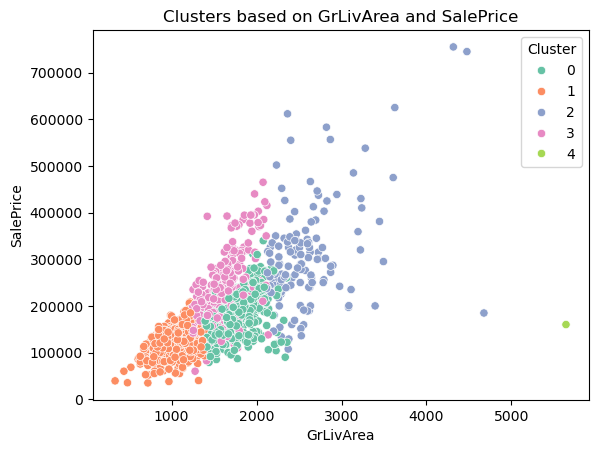

In [12]:
# visualize clusters
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', hue='Cluster', palette='Set2')
plt.title('Clusters based on GrLivArea and SalePrice')
plt.show()

In [14]:
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")
test['SalePrice'] = None  # Add empty column to align with train
combined = pd.concat([train, test], axis=0)
combined.to_csv("combined_data.csv", index=False)